#Bioacoustics AIMS 2025

#Instructions on how to use this notebook
This notebook is hosted on ``Google Colab``. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using ``Colab`` entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

In [ ]:
#Run this cell
!pip install git+https://github.com/google-research/perch-hoplite.git

  Cloning https://github.com/google-research/perch-hoplite.git to /tmp/pip-req-build-a1fpatp4
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/perch-hoplite.git /tmp/pip-req-build-a1fpatp4
  Resolved https://github.com/google-research/perch-hoplite.git to commit b075df9dfe2eedbaebfd3e97a52b4cffe3569fe2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.9 MB/s eta 0:00:00
   ━━━

#Import the requirement librairies

In [7]:
import librosa
import numpy as np
import os
from etils import epath
import csv
import pandas as pd
import collections
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Building a Dataset

We will be using [PowderMill Annotated Dataset](https://zenodo.org/records/4656848#.Y7ijhOxudhE) for this Lab. This dataset has been uploaded to Google Cloud Storage for easier access.

In [8]:
#Run this cell to load the Powdermill dataset and its annotations from Google Cloud Storage
rec_path = epath.Path('gs://chirp-public-bucket/soundscapes/powdermill/Recording_2')
annos_path = epath.Path('gs://chirp-public-bucket/soundscapes/powdermill/powdermill.csv')

In [9]:
print("Files inside Recording_2:")
for fp in rec_path.iterdir():
    print(" •", fp)

Files inside Recording_2:
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_01.Table.1.selections.txt
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_01.wav
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_02.Table.1.selections.txt
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_02.wav
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_03.Table.1.selections.txt
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_03.wav
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_04.Table.1.selections.txt
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_04.wav
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_05.Table.1.selections.txt
 • gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Record

In [10]:
print("\nFirst 5 lines of the annotations file:")
with annos_path.open() as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        print(row)
        if i == 4:   # only show the first 5 rows
            break


First 5 lines of the annotations file:
['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)', 'High Freq (Hz)', 'Low Freq (Hz)', 'Species', 'Filename']
['1', 'Spectrogram 1', '1', '154.387792767', '154.911598217', '2878.2', '4049.0', 'EATO', 'Recording_1/Recording_1_Segment_02.wav']
['2', 'Spectrogram 1', '1', '167.526598245', '168.17302044', '2731.9', '3902.7', 'EATO', 'Recording_1/Recording_1_Segment_02.wav']
['3', 'Spectrogram 1', '1', '183.609636834', '184.097751553', '2878.2', '3975.8', 'EATO', 'Recording_1/Recording_1_Segment_02.wav']
['4', 'Spectrogram 1', '1', '250.527480604', '251.160710509', '2756.2', '3951.4', 'EATO', 'Recording_1/Recording_1_Segment_02.wav']


In [12]:
# Read and list all the wav files in the recording path.
# We convert the glob generator directly to a list and sort it for consistency.
wav_files = sorted(list(rec_path.glob("*.wav")))

# Print results so we can see what we found
print(f"Number of WAV files found: {len(wav_files)}")

for file_path in wav_files:
    print(f" - {file_path}")


Number of WAV files found: 14
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_01.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_02.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_03.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_04.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_05.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_06.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_07.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_08.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_09.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recording_2_Segment_10.wav
 - gs://chirp-public-bucket/soundscapes/powdermill/Recording_2/Recordi

In [20]:
all_specs = []  # holds all spectrograms
segment_info = []  # metadata (file, start, end time)

segment_length = 5.0  # seconds

for fp in wav_files:
    local_path = f"/tmp/{fp.name}"
    # Add a check: only copy if the local file does not already exist
    if not os.path.exists(local_path):
        fp.copy(local_path)

    # now librosa can safely read it
    audio, sr = librosa.load(local_path, sr=None)

    samples_per_segment = int(segment_length * sr)
    num_segments = len(audio) // samples_per_segment

    # loop over each 5-second chunk
    for i in range(num_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment

        segment = audio[start:end]

        # create mel-spectrogram
        spec = librosa.feature.melspectrogram(
            y=segment,
            sr=sr,
            n_mels=128
        )
        spec_db = librosa.power_to_db(spec, ref=np.max)

        # save spectrogram
        all_specs.append(spec_db)

        # save metadata
        segment_info.append({
            "file": fp.name,
            "start_time": start / sr,
            "end_time": end / sr
        })

# convert lists to final structures
all_specs = np.array(all_specs, dtype=object)
segment_df = pd.DataFrame(segment_info)

print("Total spectrograms created:", len(all_specs))
segment_df.head()

Total spectrograms created: 840


,file,start_time,end_time
0,Recording_2_Segment_01.wav,0.0,5.0
1,Recording_2_Segment_01.wav,5.0,10.0
2,Recording_2_Segment_01.wav,10.0,15.0
3,Recording_2_Segment_01.wav,15.0,20.0
4,Recording_2_Segment_01.wav,20.0,25.0


In [15]:
#(i) Read the annotations file and list all species

species = set()
with annos_path.open() as f:
    reader = csv.DictReader(f)
    for row in reader:
        species.add(row["Species"])

print("All species:", species)


All species: {'BAOR', 'CSWA', 'VEER', 'BAWW', 'PIWO', 'NOFL', 'EAWP', 'WOTH', 'BCCH', 'BWWA', 'RWBL', 'BTNW', 'LOWA', 'BLJA', 'TUTI', 'KEWA', 'NAWA', 'BGGN', 'REVI', 'WBNU', 'NOCA', 'HETH', 'CEDW', 'CORA', 'EATO', 'BHVI', 'OVEN', 'DOWO', 'AMRO', 'AMCR', 'HOWA', 'AMGO', 'SCTA', 'COYE', 'BBWA', 'RCKI', 'CARW', 'YBCU', 'RBGR', 'SWTH', 'RBWO', 'BRCR', 'BHCO', 'WITU', 'AMRE', 'CANG', 'RSHA', 'HAWO'}


In [16]:
# Let's work with EATO, which is the Eastern Towhee.
eato_annos = []

# Read annotations and filter for EATO species, storing filename as well
with annos_path.open() as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["Species"] == "EATO":
            eato_annos.append({
                "file": os.path.basename(row["Filename"]),
                "begin_time": float(row["Begin Time (s)"]),
                "end_time": float(row["End Time (s)"])
            })

# Create an array of EATO labels for each spectrogram
eato_labels = []

# Iterate through each spectrogram segment's metadata
for idx, segment_row in segment_df.iterrows():
    window_file = segment_row["file"]
    window_start = segment_row["start_time"]
    window_end = segment_row["end_time"]
    contains_eato = 0  # Initialize label to 0

    # Check for overlapping annotations with each spectrogram segment from the same file
    for anno in eato_annos:
        if anno["file"] == window_file:  # Only check annotations from the same file
            anno_start = anno["begin_time"]
            anno_end = anno["end_time"]
            # Overlap condition: anno_start < window_end AND anno_end > window_start
            if anno_start < window_end and anno_end > window_start:
                contains_eato = 1  # Set label to 1 (EATO present)
                break  # No need to check other annotations for this window
    eato_labels.append(contains_eato)

# Convert to numpy array
eato_labels = np.array(eato_labels)

print("Number of EATO labels created:", len(eato_labels))
print("Number of spectrograms with EATO calls:", np.sum(eato_labels))


Number of EATO labels created: 840
Number of spectrograms with EATO calls: 284


#Classification

In [19]:
flat_specs = np.array([s.flatten() for s in all_specs])
print("Shape of flattened spectrograms:", flat_specs.shape)


#PCA dimensionality reduction
pca = PCA(n_components=50)   # keep top 50 principal components
X = pca.fit_transform(flat_specs)
print("Shape after PCA:", X.shape)

#Labels
y = np.array(eato_labels)
print("Labels shape:", y.shape)


#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Logistic Regression classifier
clf = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=42)
clf.fit(X_train_scaled, y_train)

#Evaluate
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("\nResults")
print(f"Number of PCA components: 50")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Accuracy on the test set: {accuracy:.4f}")


Shape of flattened spectrograms: (840, 40064)
Shape after PCA: (840, 50)
Labels shape: (840,)

Results
Number of PCA components: 50
Training samples: 588
Testing samples: 252
Accuracy on the test set: 0.6786


In [18]:
#Define the main annotations file path globally
annos_path = epath.Path('gs://chirp-public-bucket/soundscapes/powdermill/powdermill.csv')

def process_recording(recording_path_gs: epath.Path, annos_path_gs: epath.Path):
    """
    Loads WAV files from a GCS recording path, generates 5-second mel-spectrograms,
    and creates EATO labels based on provided annotations.

    Args:
        recording_path_gs: etils.epath.Path object to the GCS recording directory.
        annos_path_gs: etils.epath.Path object to the GCS annotations CSV file.

    Returns:
        Tuple of (all_specs_list, eato_labels_array).
        all_specs_list: A list of 2D numpy arrays (mel-spectrograms).
        eato_labels_array: A 1D numpy array of binary EATO labels.
    """
    print(f"Processing recording: {recording_path_gs.name}")

    wav_files = list(recording_path_gs.glob("*.wav"))

    all_specs = []       #holds all spectrograms
    segment_info = []    #metadata (file, start, end time)
    segment_length = 5.0 #seconds

    for fp in wav_files:
        local_path = f"/tmp/{fp.name}"

        # Copy GCS file to local if it doesn't exist
        if not os.path.exists(local_path):
            fp.copy(local_path)

        audio, sr = librosa.load(local_path, sr=None)

        samples_per_segment = int(segment_length * sr)
        num_segments = len(audio) // samples_per_segment

        for i in range(num_segments):
            start = i * samples_per_segment
            end = start + samples_per_segment
            segment = audio[start:end]

            spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
            spec_db = librosa.power_to_db(spec, ref=np.max)

            all_specs.append(spec_db)
            segment_info.append({
                "file": fp.name,
                "start_time": start / sr,
                "end_time": end / sr
            })


    segment_df = pd.DataFrame(segment_info)

    #Load EATO annotations, including filename
    eato_annos = []
    with annos_path_gs.open() as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["Species"] == "EATO":
                eato_annos.append({
                    "file": os.path.basename(row["Filename"]),
                    "begin_time": float(row["Begin Time (s)"]),
                    "end_time": float(row["End Time (s)"])
                })

    #Generate EATO labels for spectrograms
    eato_labels = []
    for idx, segment_row in segment_df.iterrows():
        window_file = segment_row["file"]
        window_start = segment_row["start_time"]
        window_end = segment_row["end_time"]
        contains_eato = 0

        for anno in eato_annos:
            if anno["file"] == window_file:
                anno_start = anno["begin_time"]
                anno_end = anno["end_time"]
                if anno_start < window_end and anno_end > window_start:
                    contains_eato = 1
                    break
        eato_labels.append(contains_eato)

    return all_specs, np.array(eato_labels)



# List of the recording paths to evaluate
other_recording_paths = [
    epath.Path('gs://chirp-public-bucket/soundscapes/powdermill/Recording_1'),
    epath.Path('gs://chirp-public-bucket/soundscapes/powdermill/Recording_3'),
    epath.Path('gs://chirp-public-bucket/soundscapes/powdermill/Recording_4')
]

print("\n Evaluating model on other recordings ")

for rec_path in other_recording_paths:
    new_all_specs, new_eato_labels = process_recording(rec_path, annos_path)

    #Flatten spectrograms for PCA (same as before)
    new_flat_specs = np.array([s.flatten() for s in new_all_specs])

    #Apply PCA (using the *already fitted* pca object from Recording_2 data)
    X_new_pca = pca.transform(new_flat_specs)

    #Scale features (using the *already fitted* scaler object from Recording_2 data)
    X_new_scaled = scaler.transform(X_new_pca)

    #Predict probabilities using the *already trained* classifier
    y_pred_proba = clf.predict_proba(X_new_scaled)[:, 1] # Get probability of positive class

    #Compute ROC-AUC score
    if len(np.unique(new_eato_labels)) < 2:
        print(f"  -> Skipping ROC-AUC for {rec_path.name}: Only one class present in labels.")
    else:
        roc_auc = roc_auc_score(new_eato_labels, y_pred_proba)
        print(f"  ROC-AUC score for {rec_path.name}: {roc_auc:.4f}\n")


 Evaluating Model on Other Recordings 
Processing recording: Recording_1
  ROC-AUC score for Recording_1: 0.5053

Processing recording: Recording_3
  -> Skipping ROC-AUC for Recording_3: Only one class present in labels.
Processing recording: Recording_4
  ROC-AUC score for Recording_4: 0.5426



/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


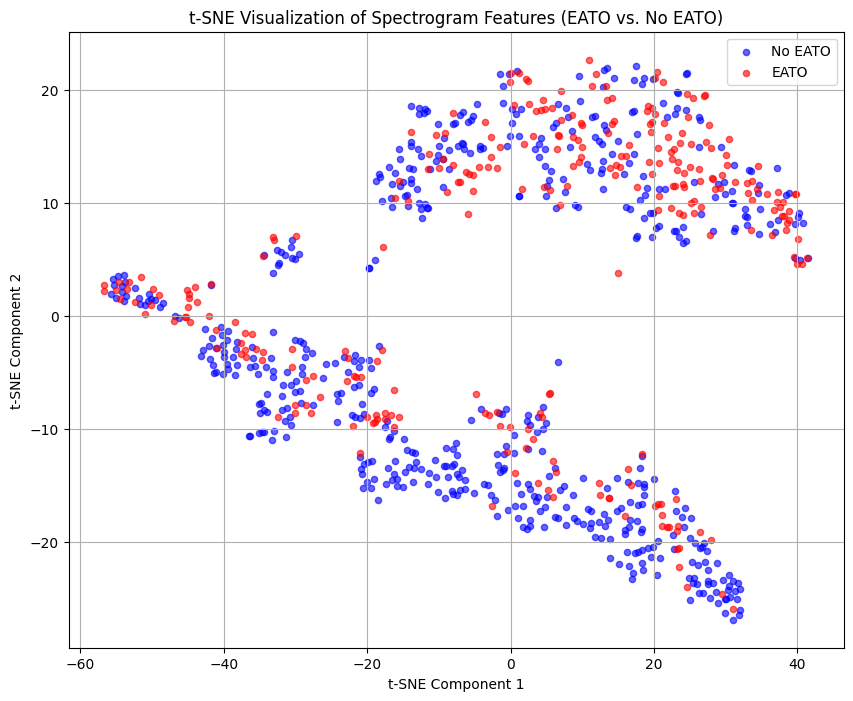

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

if reduced_specs.dtype == object:
    # If it's an object array of 1D arrays, stack them
    data_for_tsne = np.vstack(reduced_specs)
else:
    data_for_tsne = reduced_specs

# Ensure `eato_labels` is a flat array
labels_for_plot = np.asarray(eato_labels).flatten()

X_tsne = tsne.fit_transform(data_for_tsne)

# 2. Plot the points, colored according to the EATO label
plt.figure(figsize=(10, 8))

# Separate data points by label for clearer plotting and legend
points_eato = X_tsne[labels_for_plot == 1]
points_no_eato = X_tsne[labels_for_plot == 0]

plt.scatter(points_no_eato[:, 0], points_no_eato[:, 1], c='blue', label='No EATO', alpha=0.6, s=20)
plt.scatter(points_eato[:, 0], points_eato[:, 1], c='red', label='EATO', alpha=0.6, s=20)

plt.title('t-SNE Visualization of Spectrogram Features (EATO vs. No EATO)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()

